In [35]:
import pandas as pd

df = pd.read_csv('DataTrain/fixed_dataset.csv', header=None ).drop(0)
df.columns=['index', 'text', 'label']
df

,index,text,label
1,0.0,"pilgub kemarin banyak boong nya , hasil nya di...",negative
2,1.0,"hti , wahabi , pks , fpi ikut2an menyerbu kiai...",negative
3,2.0,"malas makan oreo , suka bikin gigi hitam",negative
4,3.0,lagi asik menonton di bioskop ada iklan pemeri...,negative
5,4.0,adeh . di mana letak muka nya itu orang . tida...,negative
...,...,...,...
3440,3439.0,pkb benarkan charly setia band daftar jadi caw...,neutral
3441,3440.0,pernah percaya kalau body lotion citra bikin b...,neutral
3442,3441.0,"bu susi marah , menteri luhut perbolehkan kapa...",neutral
3443,3442.0,f - demokrat dorong upaya kemandirian energi n...,neutral


In [34]:
df.head

<bound method NDFrame.head of        index                                               text     label
0        NaN                                               text     label
1        0.0  pilgub kemarin banyak boong nya , hasil nya di...  negative
2        1.0  hti , wahabi , pks , fpi ikut2an menyerbu kiai...  negative
3        2.0           malas makan oreo , suka bikin gigi hitam  negative
4        3.0  lagi asik menonton di bioskop ada iklan pemeri...  negative
...      ...                                                ...       ...
3440  3439.0  pkb benarkan charly setia band daftar jadi caw...   neutral
3441  3440.0  pernah percaya kalau body lotion citra bikin b...   neutral
3442  3441.0  bu susi marah , menteri luhut perbolehkan kapa...   neutral
3443  3442.0  f - demokrat dorong upaya kemandirian energi n...   neutral
3444  3443.0        hormati partai-partai yang telah berkoalisi   neutral

[3445 rows x 3 columns]>

In [36]:
df.shape

(3444, 3)

In [37]:
df.label.value_counts()

negative    1148
positive    1148
neutral     1148
Name: label, dtype: int64

In [38]:
import re
def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [39]:
df['text_clean'] = df.text.apply(cleansing)

In [40]:
df.head()

,index,text,label,text_clean
1,0.0,"pilgub kemarin banyak boong nya , hasil nya di...",negative,pilgub kemarin banyak boong nya hasil nya di...
2,1.0,"hti , wahabi , pks , fpi ikut2an menyerbu kiai...",negative,hti wahabi pks fpi ikut2an menyerbu kiai...
3,2.0,"malas makan oreo , suka bikin gigi hitam",negative,malas makan oreo suka bikin gigi hitam
4,3.0,lagi asik menonton di bioskop ada iklan pemeri...,negative,lagi asik menonton di bioskop ada iklan pemeri...
5,4.0,adeh . di mana letak muka nya itu orang . tida...,negative,adeh di mana letak muka nya itu orang tida...


In [41]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [42]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 1148, Neu: 1148, Neg: 1148
Total data: 3444


In [43]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [44]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [46]:
from sklearn.model_selection import train_test_split
file = open("API/resources_of_lstm/x_pad_sequences.pickle", 'rb')
X = pickle.load(file)
file.close()

file = open("API/resources_of_lstm/y_labels.pickle", 'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [47]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [49]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 96, 100)           10000000  
                                                                 
 lstm_7 (LSTM)               (None, 64)                42240     
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
276/276 [==============================] - 40s 138ms/step - loss: 0.6799 - accuracy: 0.7125 - val_loss: 0.4463 - val_accuracy: 0.8258
Epoch 2/10
276/276 [==============================] - 38s 137ms/step - loss: 0.2721 - accuracy: 0.9027 - val_loss: 0.4789 - val_accuracy: 0.8316
Epoch 3/10


In [50]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

22/22 [==============================] - 1s 10ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       232
           1       0.88      0.84      0.86       218
           2       0.79      0.85      0.82       239

    accuracy                           0.81       689
   macro avg       0.81      0.81      0.81       689
weighted avg       0.81      0.81      0.81       689



In [51]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42, shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test   = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

22/22 [==============================] - 0s 10ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       232
           1       0.83      0.92      0.88       218
           2       0.87      0.82      0.84       239

    accuracy                           0.83       689
   macro avg       0.83      0.83      0.83       689
weighted avg       0.83      0.83      0.83       689

22/22 [==============================] - 0s 10ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       232
           1       0.91      0.89      0.90       218
           2       0.83      0.86      0.84       239

    accuracy                           0.85       689
   macro avg       0.85      0.85      0.85       689
weighted avg       0.85      0.85      0.85       689

22/22 [==============================] - 0s 10ms/step
Training ke- 3
              precision    reca

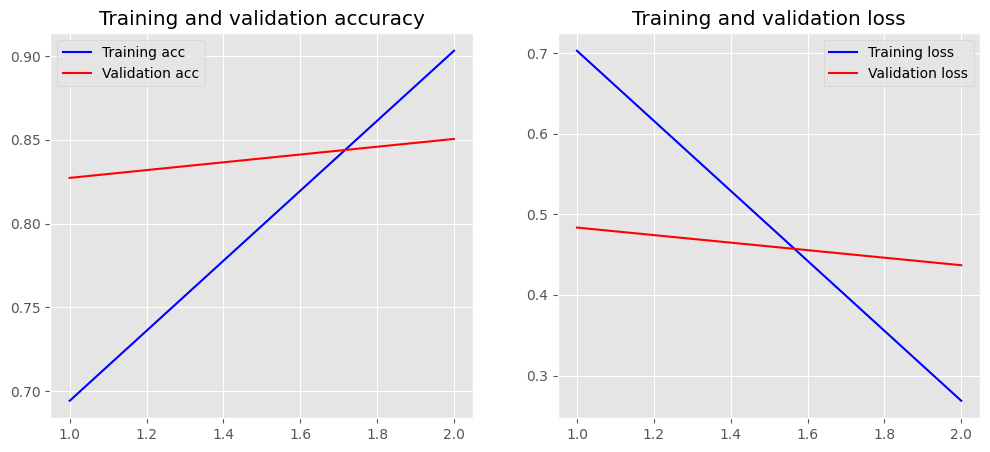

In [52]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [53]:
model.save('model.h5')
print("Model has created!")

Model has created!


In [54]:
import re
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing(sent):

    string = sent.lower()

    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [55]:
sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('API/resources_of_lstm/model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 297ms/step
Text:   rasa syukur  cukup  
Sentiment:  negative
